# Austin Crime and Property Analysis

### Over time, does a change in crime, and specifically violent and property crime, influence housing prices? 


## Hypothesis
### Our hypothesis is that an increase in violent crimes, over a period, will negatively impact home prices in an Austin zip code.  Conversely, a decrease in violent crime, over a period, will positively impact home prices in an Austin zip code.!

### Datasource used.
* US Cencus Data (Pupulation by zipcode)
* MLS listing data (zipcode, listing date, listing price)
* austintexas.gov (zipcode, crime type, occurance date)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import requests
import json
from matplotlib import pyplot as plt
%matplotlib inline
import gmaps
import calendar
from scipy.stats import linregress

In [3]:
# Import API key
from config import api_key
gkey = api_key

## Read Austin Crimedata

In [4]:
# Read the crime data cvs file
crimedata_df = pd.read_csv("Datasets/AustinCrimeDataset/crimedata.csv")
crimedata_df.head()

,zip_code,crime_type,category_description,occ_date_time,latitude,longitude
0,78741.0,FAMILY DISTURBANCE,NaN,2019-09-07T19:22:00.000,30.224783,-97.694979
1,78701.0,ASSAULT WITH INJURY,NaN,2019-09-07T19:00:00.000,30.267976,-97.737619
2,78741.0,THEFT OF BICYCLE,Theft,2019-09-07T18:30:00.000,30.235814,-97.722624
3,78702.0,FRAUD - OTHER,NaN,2019-09-07T16:32:00.000,30.263098,-97.706199
4,78751.0,ASSAULT BY CONTACT,NaN,2019-09-07T15:00:00.000,30.307651,-97.735350


In [5]:
# Check the type
crimedata_df.dtypes

zip_code                float64
crime_type               object
category_description     object
occ_date_time            object
latitude                float64
longitude               float64
dtype: object

In [6]:
crimedata_df.count()

zip_code                545325
crime_type              550000
category_description    186852
occ_date_time           550000
latitude                538447
longitude               538447
dtype: int64

In [7]:
# Drop the rows without zipcode.
crimedata_df = crimedata_df.dropna(subset=["zip_code"])

In [8]:
# Check that there is no null value in zipcode column.
crimedata_df.count()

zip_code                545325
crime_type              545325
category_description    186196
occ_date_time           545325
latitude                537752
longitude               537752
dtype: int64

In [9]:
# some of the crime type doesn't have categories description. Fill those categories with "Others".
crimedata_df["category_description"].fillna("Other", inplace=True)
crimedata_df.count()
# Latitude and longitude has Nan values, those rows will be dropped when lat and lng need to be considered.

zip_code                545325
crime_type              545325
category_description    545325
occ_date_time           545325
latitude                537752
longitude               537752
dtype: int64

In [10]:
crimedata_df["category_description"].value_counts()

Other                 359129
Theft                 133615
Burglary               22967
Auto Theft             11045
Aggravated Assault     10326
Robbery                 4746
Rape                    3340
Murder                   157
Name: category_description, dtype: int64

In [11]:
# Seperate date and time from timestamp.
crimedata_df["Dates"] = pd.to_datetime(crimedata_df["occ_date_time"]).dt.date
crimedata_df["Time"] = pd.to_datetime(crimedata_df["occ_date_time"]).dt.time
crimedata_df["zip_code"] = (crimedata_df["zip_code"]).astype(int)
crimedata_df.head()

,zip_code,crime_type,category_description,occ_date_time,latitude,longitude,Dates,Time
0,78741,FAMILY DISTURBANCE,Other,2019-09-07T19:22:00.000,30.224783,-97.694979,2019-09-07,19:22:00
1,78701,ASSAULT WITH INJURY,Other,2019-09-07T19:00:00.000,30.267976,-97.737619,2019-09-07,19:00:00
2,78741,THEFT OF BICYCLE,Theft,2019-09-07T18:30:00.000,30.235814,-97.722624,2019-09-07,18:30:00
3,78702,FRAUD - OTHER,Other,2019-09-07T16:32:00.000,30.263098,-97.706199,2019-09-07,16:32:00
4,78751,ASSAULT BY CONTACT,Other,2019-09-07T15:00:00.000,30.307651,-97.735350,2019-09-07,15:00:00


In [12]:
# Get the total crime data for the years 2015 to 2018
start_date = '01-01-2015'
end_date = '12-31-2018'
crimedata_df['Dates'] = pd.to_datetime(crimedata_df['Dates'])
target_dates = (crimedata_df['Dates'] >= start_date) & (crimedata_df['Dates'] <= end_date)

crime2015to2018_df =  crimedata_df.loc[target_dates]
crime2015to2018_df.to_csv("Datasets/AustinCrimeDataset/crime2015to2018.csv")
crime2015to2018_df.head()

,zip_code,crime_type,category_description,occ_date_time,latitude,longitude,Dates,Time
71825,78702,BURGLARY OF VEHICLE,Theft,2018-12-31T23:58:00.000,30.262470,-97.727980,2018-12-31,23:58:00
71826,78752,DEADLY CONDUCT,Aggravated Assault,2018-12-31T23:54:00.000,30.339849,-97.706618,2018-12-31,23:54:00
71827,78702,BURGLARY OF VEHICLE,Theft,2018-12-31T23:50:00.000,30.260316,-97.728247,2018-12-31,23:50:00
71828,78731,POSSESSION OF MARIJUANA,Other,2018-12-31T23:46:00.000,30.309252,-97.752412,2018-12-31,23:46:00
71829,78704,CRASH/FAIL STOP AND RENDER AID,Other,2018-12-31T23:40:00.000,30.246972,-97.735298,2018-12-31,23:40:00


In [13]:
# convert Longitude and latitude to numeric
crime2015to2018_df["latitude"] = pd.to_numeric(crime2015to2018_df["latitude"])
crime2015to2018_df["longitude"] = pd.to_numeric(crime2015to2018_df["longitude"])

In [14]:
# Add month and day name inthe dataframe.
crime2015to2018_df["Month"] = pd.to_datetime(crime2015to2018_df["Dates"]).dt.month
crime2015to2018_df["Day"] = pd.to_datetime(crime2015to2018_df["Dates"]).dt.day_name()
crime2015to2018_df.rename(columns={"zip_code": "ZipCode"}, inplace=True)
crime2015to2018_df.head()

,ZipCode,crime_type,category_description,occ_date_time,latitude,longitude,Dates,Time,Month,Day
71825,78702,BURGLARY OF VEHICLE,Theft,2018-12-31T23:58:00.000,30.262470,-97.727980,2018-12-31,23:58:00,12,Monday
71826,78752,DEADLY CONDUCT,Aggravated Assault,2018-12-31T23:54:00.000,30.339849,-97.706618,2018-12-31,23:54:00,12,Monday
71827,78702,BURGLARY OF VEHICLE,Theft,2018-12-31T23:50:00.000,30.260316,-97.728247,2018-12-31,23:50:00,12,Monday
71828,78731,POSSESSION OF MARIJUANA,Other,2018-12-31T23:46:00.000,30.309252,-97.752412,2018-12-31,23:46:00,12,Monday
71829,78704,CRASH/FAIL STOP AND RENDER AID,Other,2018-12-31T23:40:00.000,30.246972,-97.735298,2018-12-31,23:40:00,12,Monday


In [15]:
# Total crime per category.
crime2015to2018_df["category_description"].value_counts()

Other                 289840
Theft                 104969
Burglary               18521
Auto Theft              8425
Aggravated Assault      8268
Robbery                 3765
Rape                    2794
Murder                   118
Name: category_description, dtype: int64

In [16]:
# Just considering violent (Aggravated Assault, Murder, Rape, Roibbery) and property crime(Theft, Burglary, Auto Theft).
vpcrime2015to2018_df = crime2015to2018_df[crime2015to2018_df.category_description != "Other"]
vpcrime2015to2018_df.count()

ZipCode                 146860
crime_type              146860
category_description    146860
occ_date_time           146860
latitude                143778
longitude               143778
Dates                   146860
Time                    146860
Month                   146860
Day                     146860
dtype: int64

In [17]:
# Get the crime data for the years 2015.
start_date = "01-01-2015"
end_date = "12-31-2015"
target_dates = (vpcrime2015to2018_df['Dates'] >= start_date) & (vpcrime2015to2018_df['Dates'] <= end_date)

crime2015_df =  vpcrime2015to2018_df.loc[target_dates]
crime2015_df.to_csv("Datasets/AustinCrimeDataset/crime2015.csv")
crime2015_df.head()

,ZipCode,crime_type,category_description,occ_date_time,latitude,longitude,Dates,Time,Month,Day
395718,78701,THEFT FROM PERSON,Theft,2015-12-31T23:50:00.000,30.267031,-97.739818,2015-12-31,23:50:00,12,Thursday
395729,78701,THEFT,Theft,2015-12-31T23:00:00.000,30.266813,-97.739273,2015-12-31,23:00:00,12,Thursday
395731,78744,AUTO THEFT,Auto Theft,2015-12-31T23:00:00.000,30.211648,-97.752813,2015-12-31,23:00:00,12,Thursday
395732,78701,THEFT,Theft,2015-12-31T23:00:00.000,30.267083,-97.740105,2015-12-31,23:00:00,12,Thursday
395733,78701,THEFT,Theft,2015-12-31T23:00:00.000,30.260101,-97.739215,2015-12-31,23:00:00,12,Thursday


In [18]:
crime2015_df.count()

ZipCode                 38403
crime_type              38403
category_description    38403
occ_date_time           38403
latitude                37653
longitude               37653
Dates                   38403
Time                    38403
Month                   38403
Day                     38403
dtype: int64

In [19]:
# Get the crime data for the years 2016.
start_date = "01-01-2016"
end_date = "12-31-2016"
target_dates = (vpcrime2015to2018_df['Dates'] >= start_date) & (vpcrime2015to2018_df['Dates'] <= end_date)

crime2016_df =  vpcrime2015to2018_df.loc[target_dates]
crime2016_df.to_csv("Datasets/AustinCrimeDataset/crime2016.csv")
crime2016_df.head()

,ZipCode,crime_type,category_description,occ_date_time,latitude,longitude,Dates,Time,Month,Day
282967,78701,THEFT FROM PERSON,Theft,2016-12-31T23:20:00.000,30.267185,-97.738461,2016-12-31,23:20:00,12,Saturday
282968,78725,AGG ROBBERY/DEADLY WEAPON,Robbery,2016-12-31T23:18:00.000,30.279739,-97.645403,2016-12-31,23:18:00,12,Saturday
282970,78745,BURGLARY OF RESIDENCE,Burglary,2016-12-31T23:02:00.000,30.191480,-97.775542,2016-12-31,23:02:00,12,Saturday
282973,78750,AUTO THEFT,Auto Theft,2016-12-31T23:00:00.000,30.443136,-97.787508,2016-12-31,23:00:00,12,Saturday
282974,78701,THEFT,Theft,2016-12-31T23:00:00.000,30.266787,-97.739181,2016-12-31,23:00:00,12,Saturday


In [20]:
crime2016_df.count()

ZipCode                 37002
crime_type              37002
category_description    37002
occ_date_time           37002
latitude                36222
longitude               36222
Dates                   37002
Time                    37002
Month                   37002
Day                     37002
dtype: int64

In [21]:
# Get the crime data for the years 2017.
start_date = "01-01-2017"
end_date = "12-31-2017"
target_dates = (vpcrime2015to2018_df['Dates'] >= start_date) & (vpcrime2015to2018_df['Dates'] <= end_date)

crime2017_df =  vpcrime2015to2018_df.loc[target_dates]
crime2017_df.to_csv("Datasets/AustinCrimeDataset/crime2017.csv")
crime2017_df.head()

,ZipCode,crime_type,category_description,occ_date_time,latitude,longitude,Dates,Time,Month,Day
173991,78752,DEADLY CONDUCT,Aggravated Assault,2017-12-31T23:39:00.000,30.325044,-97.694710,2017-12-31,23:39:00,12,Sunday
173994,78701,BURGLARY OF VEHICLE,Theft,2017-12-31T23:30:00.000,30.265534,-97.737491,2017-12-31,23:30:00,12,Sunday
173995,78701,AUTO THEFT,Auto Theft,2017-12-31T23:30:00.000,30.266819,-97.734672,2017-12-31,23:30:00,12,Sunday
173996,78741,THEFT,Theft,2017-12-31T23:30:00.000,30.226253,-97.744786,2017-12-31,23:30:00,12,Sunday
173997,78741,AGG ASLT STRANGLE/SUFFOCATE,Aggravated Assault,2017-12-31T23:27:00.000,30.231785,-97.733584,2017-12-31,23:27:00,12,Sunday


In [22]:
crime2017_df.count()

ZipCode                 34760
crime_type              34760
category_description    34760
occ_date_time           34760
latitude                33941
longitude               33941
Dates                   34760
Time                    34760
Month                   34760
Day                     34760
dtype: int64

In [23]:
# Get the crime data for the years 2018.
start_date = "01-01-2018"
end_date = "12-31-2018"
target_dates = (vpcrime2015to2018_df['Dates'] >= start_date) & (vpcrime2015to2018_df['Dates'] <= end_date)

crime2018_df =  vpcrime2015to2018_df.loc[target_dates]
crime2018_df.to_csv("Datasets/AustinCrimeDataset/crime2018.csv")
crime2018_df.head()

,ZipCode,crime_type,category_description,occ_date_time,latitude,longitude,Dates,Time,Month,Day
71825,78702,BURGLARY OF VEHICLE,Theft,2018-12-31T23:58:00.000,30.262470,-97.727980,2018-12-31,23:58:00,12,Monday
71826,78752,DEADLY CONDUCT,Aggravated Assault,2018-12-31T23:54:00.000,30.339849,-97.706618,2018-12-31,23:54:00,12,Monday
71827,78702,BURGLARY OF VEHICLE,Theft,2018-12-31T23:50:00.000,30.260316,-97.728247,2018-12-31,23:50:00,12,Monday
71832,78701,THEFT,Theft,2018-12-31T23:30:00.000,30.267583,-97.739930,2018-12-31,23:30:00,12,Monday
71841,78758,BURGLARY OF VEHICLE,Theft,2018-12-31T23:00:00.000,30.404854,-97.713715,2018-12-31,23:00:00,12,Monday


In [24]:
crime2018_df.count()

ZipCode                 36695
crime_type              36695
category_description    36695
occ_date_time           36695
latitude                35962
longitude               35962
Dates                   36695
Time                    36695
Month                   36695
Day                     36695
dtype: int64

## Crime analysis by ZipCode 

In [25]:
# Total crime grouped by zip code
zipcrime_2015to2018 = crime2015_df.groupby("ZipCode").agg({"category_description":"count","latitude": "mean", "longitude":"mean"})
zipcrime_2015to2018.columns = ["Crime2015", "Latitude", "Longitude"]
zipcrime_2015to2018["Crime2016"] = crime2016_df.groupby("ZipCode").agg({"category_description":"count"})
zipcrime_2015to2018["Crime2017"] = crime2017_df.groupby("ZipCode").agg({"category_description":"count"})
zipcrime_2015to2018["Crime2018"] = crime2018_df.groupby("ZipCode").agg({"category_description":"count"})
zipcrime_2015to2018.head()

,Crime2015,Latitude,Longitude,Crime2016,Crime2017,Crime2018
ZipCode,,,,,,
78613,385,30.471923,-97.805481,333.0,316,350.0
78617,287,30.191509,-97.638258,285.0,242,229.0
78652,13,30.141889,-97.830404,16.0,10,8.0
78653,27,30.369627,-97.612241,49.0,39,57.0
78660,118,30.435105,-97.659208,179.0,200,306.0


In [26]:
zipcrime_2015to2018.reset_index(inplace=True)
zipcrime_2015to2018.head()

,ZipCode,Crime2015,Latitude,Longitude,Crime2016,Crime2017,Crime2018
0,78613,385,30.471923,-97.805481,333.0,316,350.0
1,78617,287,30.191509,-97.638258,285.0,242,229.0
2,78652,13,30.141889,-97.830404,16.0,10,8.0
3,78653,27,30.369627,-97.612241,49.0,39,57.0
4,78660,118,30.435105,-97.659208,179.0,200,306.0


In [27]:
zipcrime_2015to2018["Total Crime"] = zipcrime_2015to2018[["Crime2015", "Crime2016", "Crime2017", "Crime2018"]].sum(axis=1)
zipcrime_2015to2018 = zipcrime_2015to2018[zipcrime_2015to2018["Total Crime"]>=50]
zipcrime_2015to2018.head()

,ZipCode,Crime2015,Latitude,Longitude,Crime2016,Crime2017,Crime2018,Total Crime
0,78613,385,30.471923,-97.805481,333.0,316,350.0,1384.0
1,78617,287,30.191509,-97.638258,285.0,242,229.0,1043.0
3,78653,27,30.369627,-97.612241,49.0,39,57.0,172.0
4,78660,118,30.435105,-97.659208,179.0,200,306.0,803.0
6,78701,2104,30.267940,-97.740955,2051.0,1855,2108.0,8118.0


## Reading Population data

In [28]:
#  Read Population Dataset.
population_data_2015to2018 = pd.read_csv("Datasets/AustinPopulation/AustinZipCodePopulation.csv")
population_data_2015to2018.dtypes

Zipcode            int64
2015_Population    int64
2016_Population    int64
2017_Population    int64
2018_Population    int64
dtype: object

In [29]:
population_data_2015to2018.rename(columns={"Zipcode": "ZipCode"}, inplace=True)
population_data_2015to2018.head()

,ZipCode,2015_Population,2016_Population,2017_Population,2018_Population
0,78681,54923,56086,57234,58665
1,78701,7051,7401,7875,8072
2,78702,21477,22617,22876,23448
3,78703,20530,20815,20788,21308
4,78704,44668,46474,47158,48337


In [30]:
population_data_2015to2018["Total Population"] = population_data_2015to2018[["2015_Population", "2015_Population", "2015_Population", "2015_Population"]].sum(axis=1)
population_data_2015to2018.head()

,ZipCode,2015_Population,2016_Population,2017_Population,2018_Population,Total Population
0,78681,54923,56086,57234,58665,219692
1,78701,7051,7401,7875,8072,28204
2,78702,21477,22617,22876,23448,85908
3,78703,20530,20815,20788,21308,82120
4,78704,44668,46474,47158,48337,178672


In [31]:
# Merge Crime dataframe and Population dataframe.
pop_crime_df = pd.merge(zipcrime_2015to2018, population_data_2015to2018, on="ZipCode", how = "inner")
pop_crime_df.head()

,ZipCode,Crime2015,Latitude,Longitude,Crime2016,Crime2017,Crime2018,Total Crime,2015_Population,2016_Population,2017_Population,2018_Population,Total Population
0,78701,2104,30.267940,-97.740955,2051.0,1855,2108.0,8118.0,7051,7401,7875,8072,28204
1,78702,1670,30.264607,-97.719230,1574.0,1581,1722.0,6547.0,21477,22617,22876,23448,85908
2,78703,726,30.281178,-97.760119,654.0,601,687.0,2668.0,20530,20815,20788,21308,82120
3,78704,2577,30.240343,-97.764156,2543.0,2474,2593.0,10187.0,44668,46474,47158,48337,178672
4,78705,1335,30.290847,-97.742310,1121.0,872,985.0,4313.0,32346,32414,33075,33902,129384


In [32]:
# Crime per 1000 population for years 2015, 2016, 2017, 2018.
pop_crime_df["CrimePerPop2015"] = (pop_crime_df["Crime2015"]/pop_crime_df["2015_Population"])*1000
pop_crime_df["CrimePerPop2016"] = (pop_crime_df["Crime2016"]/pop_crime_df["2016_Population"])*1000
pop_crime_df["CrimePerPop2017"] = (pop_crime_df["Crime2017"]/pop_crime_df["2017_Population"])*1000
pop_crime_df["CrimePerPop2018"] = (pop_crime_df["Crime2018"]/pop_crime_df["2018_Population"])*1000

pop_crime_df = pop_crime_df[["ZipCode", "CrimePerPop2015", "CrimePerPop2016", "CrimePerPop2017", "CrimePerPop2018", "Latitude", "Longitude"]]
pop_crime_df["TotalCrimePerPop"] = pop_crime_df[["CrimePerPop2015", "CrimePerPop2016", "CrimePerPop2017", "CrimePerPop2018"]].sum(axis=1)
pop_crime_df.head()

,ZipCode,CrimePerPop2015,CrimePerPop2016,CrimePerPop2017,CrimePerPop2018,Latitude,Longitude,TotalCrimePerPop
0,78701,298.397390,277.124713,235.555556,261.149653,30.267940,-97.740955,1072.227312
1,78702,77.757601,69.593668,69.111733,73.439099,30.264607,-97.719230,289.902102
2,78703,35.362884,31.419649,28.910910,32.241412,30.281178,-97.760119,127.934855
3,78704,57.692308,54.718767,52.461936,53.644206,30.240343,-97.764156,218.517218
4,78705,41.272491,34.583822,26.364324,29.054333,30.290847,-97.742310,131.274970


In [33]:
high_low_cr_zip_df = pop_crime_df.set_index("ZipCode")
high_low_cr_zip_df = high_low_cr_zip_df["TotalCrimePerPop"].sort_values()
high_low_cr_zip_df = pd.concat([high_low_cr_zip_df.head(5), high_low_cr_zip_df.tail(5)])
high_low_cr_zip_df

ZipCode
78728       2.423664
78730      25.608144
78725      26.142013
78739      28.394665
78717      43.491946
78723     241.512240
78702     289.902102
78742     298.824411
78719     373.789304
78701    1072.227312
Name: TotalCrimePerPop, dtype: float64

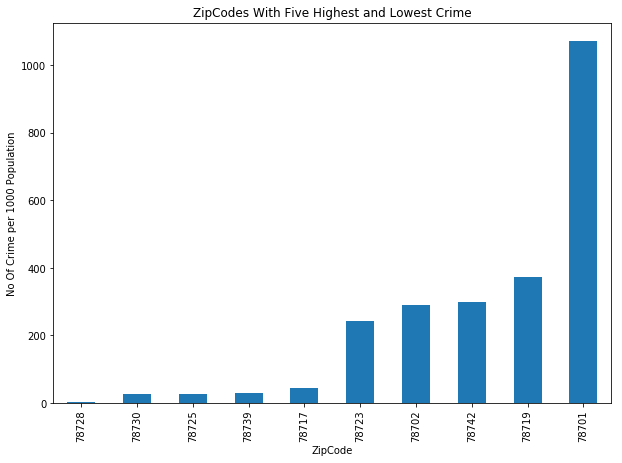

In [34]:
high_low_cr_zip_df.plot(kind="bar", figsize=(10,7))
plt.title("ZipCodes With Five Highest and Lowest Crime")
plt.ylabel("No Of Crime per 1000 Population")
plt.savefig("images/ZipcodeWithHighestAndLowestCrime.png")
plt.show()

In [35]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

# Store 'Lat' and 'Lng' into  locations 
locations = pop_crime_df[["Latitude", "Longitude"]].astype(float)
# locations[5:10]

# # Convert category_description to float and store
crime = pop_crime_df["TotalCrimePerPop"].astype(int)

# Create a total crime Heatmap layer
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=crime, point_radius=10, max_intensity=100)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [36]:
crime = pop_crime_df["TotalCrimePerPop"].astype(int)
pop_crime_df["zip_crm_column"] = "ZipCode:" + (pop_crime_df["ZipCode"]).astype(str) + ", Crime:" + crime.astype(str)
pop_crime_df.head()

,ZipCode,CrimePerPop2015,CrimePerPop2016,CrimePerPop2017,CrimePerPop2018,Latitude,Longitude,TotalCrimePerPop,zip_crm_column
0,78701,298.397390,277.124713,235.555556,261.149653,30.267940,-97.740955,1072.227312,"ZipCode:78701, Crime:1072"
1,78702,77.757601,69.593668,69.111733,73.439099,30.264607,-97.719230,289.902102,"ZipCode:78702, Crime:289"
2,78703,35.362884,31.419649,28.910910,32.241412,30.281178,-97.760119,127.934855,"ZipCode:78703, Crime:127"
3,78704,57.692308,54.718767,52.461936,53.644206,30.240343,-97.764156,218.517218,"ZipCode:78704, Crime:218"
4,78705,41.272491,34.583822,26.364324,29.054333,30.290847,-97.742310,131.274970,"ZipCode:78705, Crime:131"


In [37]:
zip_crm_lst = pop_crime_df["zip_crm_column"].tolist()
zip_code_layer = gmaps.symbol_layer(locations, hover_text=zip_crm_lst, fill_color='rgba(0, 150, 0, 0.4)',
                                   stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
                                   info_box_content=zip_crm_lst)

fig = gmaps.figure()
fig.add_layer(zip_code_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [38]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(zip_code_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [39]:
# Percentage change in crime per 1000 population from 2015 to 2018
pop_cr_for_pct_chg_df = pop_crime_df.drop(["Latitude", "Longitude","TotalCrimePerPop", "zip_crm_column"], axis=1)
pop_cr_for_pct_chg_df = pop_cr_for_pct_chg_df.set_index("ZipCode")
perc_chg_pop_crime_2015to2018 = (pop_cr_for_pct_chg_df.pct_change(axis="columns", periods=3, fill_method="ffill"))*100
perc_chg_pop_crime_2015to2018.head()

,CrimePerPop2015,CrimePerPop2016,CrimePerPop2017,CrimePerPop2018
ZipCode,,,,
78701,NaN,NaN,NaN,-12.482595
78702,NaN,NaN,NaN,-5.553800
78703,NaN,NaN,NaN,-8.826972
78704,NaN,NaN,NaN,-7.016709
78705,NaN,NaN,NaN,-29.603636


In [40]:
high_low_per_chg_cr_zip_df = perc_chg_pop_crime_2015to2018["CrimePerPop2018"].sort_values()
high_low_per_chg_cr_zip_df.head()

ZipCode
78739   -42.226029
78719   -32.826218
78747   -31.609205
78705   -29.603636
78753   -24.592798
Name: CrimePerPop2018, dtype: float64

In [41]:
zip_high_low_crime_chg = pd.concat([high_low_per_chg_cr_zip_df.head(5), high_low_per_chg_cr_zip_df.tail(5)])
zip_high_low_crime_chg

ZipCode
78739    -42.226029
78719    -32.826218
78747    -31.609205
78705    -29.603636
78753    -24.592798
78727     17.179695
78729     19.216242
78717     29.362962
78730     62.770642
78742    111.698113
Name: CrimePerPop2018, dtype: float64

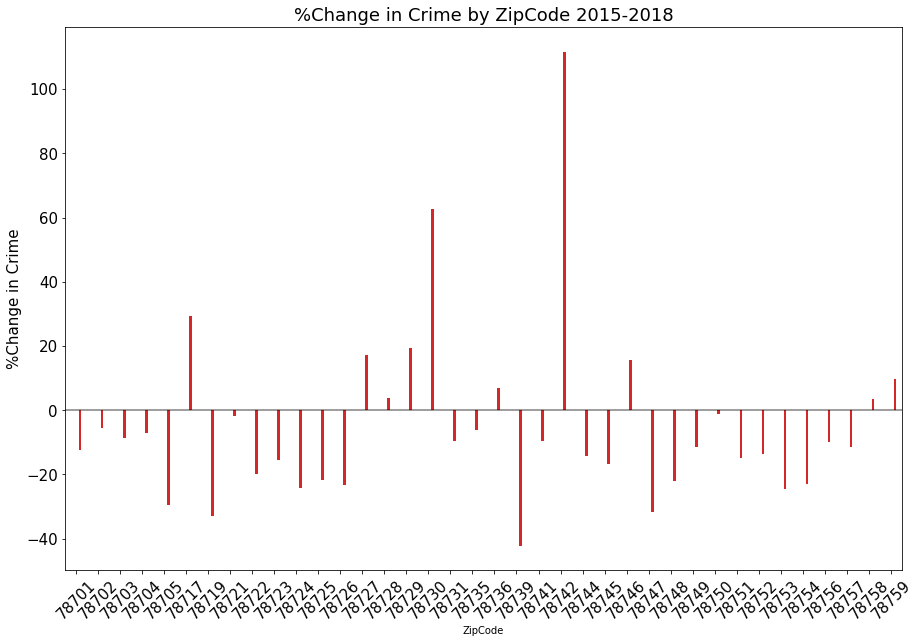

In [42]:
perc_chg_pop_crime_2015to2018.plot(kind="bar", figsize=(15,10), legend=False, rot=45, fontsize=15)
plt.title("%Change in Crime by ZipCode 2015-2018", fontsize=18)
plt.ylabel("%Change in Crime", fontsize=15)
plt.axhline(0, color="k", alpha=0.5)
plt.savefig("images/PerChgInCrimeByZipCode.png")
plt.show()

## Crime analysis by crime category

In [43]:
# Crime by category for year 2015, 2016, 2017, 2018.
crimegroup_2015to2018 = crime2015_df.groupby("category_description").agg({"category_description":"count"})
crimegroup_2015to2018.columns = ["Crime2015"]
crimegroup_2015to2018["Crime2016"] = crime2016_df.groupby("category_description").agg({"category_description":"count"})
crimegroup_2015to2018["Crime2017"] = crime2017_df.groupby("category_description").agg({"category_description":"count"})
crimegroup_2015to2018["Crime2018"] = crime2018_df.groupby("category_description").agg({"category_description":"count"})
crimegroup_2015to2018.reset_index(inplace = True)
crimegroup_2015to2018

,category_description,Crime2015,Crime2016,Crime2017,Crime2018
0,Aggravated Assault,1852,2113,2250,2053
1,Auto Theft,2001,2010,1995,2419
2,Burglary,4894,5135,4326,4166
3,Murder,24,39,25,30
4,Rape,681,702,746,665
5,Robbery,886,963,926,990
6,Theft,28065,26040,24492,26372


In [44]:
year_crime_g_2015to2018 = crimegroup_2015to2018.pivot_table(columns="category_description", values = ["Crime2015", "Crime2016", "Crime2017", "Crime2018"])
year_crime_g_2015to2018.reset_index(inplace=True)
year_crime_g_2015to2018 = year_crime_g_2015to2018.rename(columns={"index":"Year"})
year_crime_g_2015to2018 = year_crime_g_2015to2018.rename(index={"category_description":"Index"})
year_crime_g_2015to2018.set_index("Year", inplace=True)
year_crime_g_2015to2018["TotalViolentCrimePerYear"] = year_crime_g_2015to2018[["Aggravated Assault","Murder", "Rape", "Robbery"]].sum(axis=1)
year_crime_g_2015to2018["PropertyCrimePerYear"] = year_crime_g_2015to2018[["Auto Theft", "Burglary", "Theft"]].sum(axis=1)
year_crime_g_2015to2018

category_description,Aggravated Assault,Auto Theft,Burglary,Murder,Rape,Robbery,Theft,TotalViolentCrimePerYear,PropertyCrimePerYear
Year,,,,,,,,,
Crime2015,1852,2001,4894,24,681,886,28065,3443,34960
Crime2016,2113,2010,5135,39,702,963,26040,3817,33185
Crime2017,2250,1995,4326,25,746,926,24492,3947,30813
Crime2018,2053,2419,4166,30,665,990,26372,3738,32957


In [45]:
per_chg_year_g = year_crime_g_2015to2018[["TotalViolentCrimePerYear", "PropertyCrimePerYear"]]
per_chg_year_g = per_chg_year_g.pct_change()*100
per_chg_year_g

category_description,TotalViolentCrimePerYear,PropertyCrimePerYear
Year,,
Crime2015,NaN,NaN
Crime2016,10.862620,-5.077231
Crime2017,3.405816,-7.147808
Crime2018,-5.295161,6.958102


In [46]:
per_chg_year_g = per_chg_year_g.dropna(how="any")

per_chg_year_g["TotalViolentCrimePerYear"] = per_chg_year_g["TotalViolentCrimePerYear"].apply(lambda x:round(x,2))
per_chg_year_g["PropertyCrimePerYear"] = per_chg_year_g["PropertyCrimePerYear"].apply(lambda x:round(x,2))
per_chg_year_g


category_description,TotalViolentCrimePerYear,PropertyCrimePerYear
Year,,
Crime2016,10.86,-5.08
Crime2017,3.41,-7.15
Crime2018,-5.30,6.96


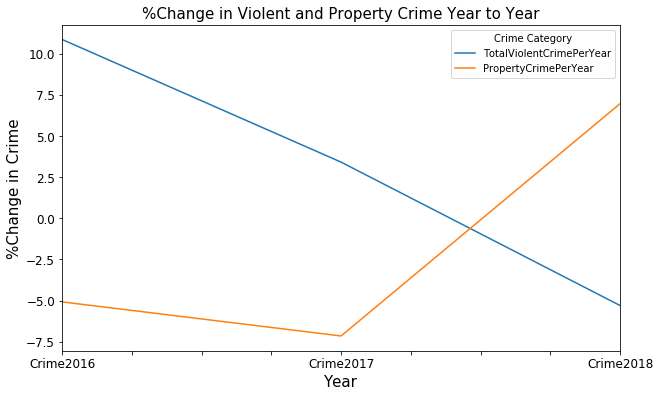

In [47]:
per_chg_year_g[["TotalViolentCrimePerYear", "PropertyCrimePerYear"]].plot(kind="line", legend = True, fontsize = 12, figsize = (10,6))
plt.ylabel("%Change in Crime", fontsize = 15)
plt.xlabel("Year", fontsize = 15)
plt.title("%Change in Violent and Property Crime Year to Year", fontsize= 15)
plt.legend(title="Crime Category")
plt.savefig("images/PerChgInCrimeOverYear.png")
plt.show()

## Crime analysis by month

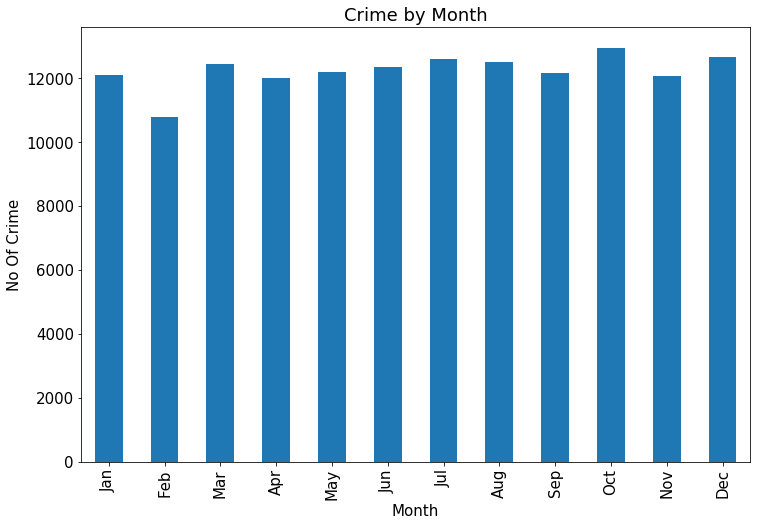

In [48]:
month_g_2015to2018_df = vpcrime2015to2018_df["Month"].value_counts()
month_g_2015to2018_df.sort_index(inplace=True)
month_g_2015to2018_df.index = map(lambda x: calendar.month_abbr[x], month_g_2015to2018_df.index)
month_g_2015to2018_df

month_g_2015to2018_df.plot(kind="bar", figsize=(12, 8), fontsize=15)
plt.title("Crime by Month", fontsize=18)
plt.xlabel("Month", fontsize=15)
plt.ylabel("No Of Crime", fontsize=15)
plt.savefig("images/CrimeByMonth.png")
plt.show()

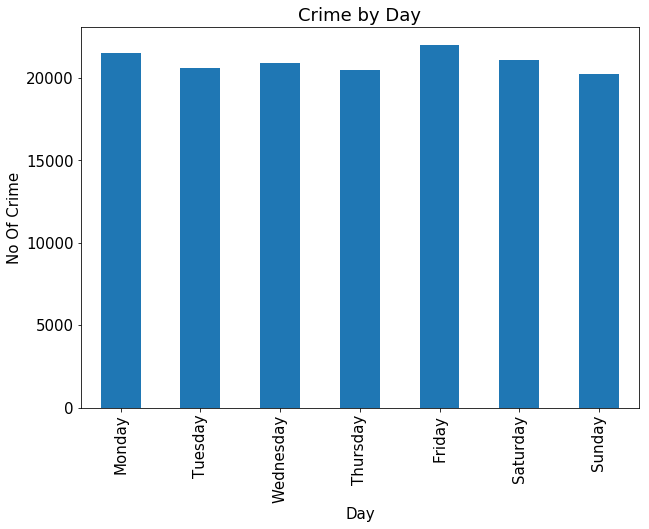

In [49]:
day_g_2015to2018_df = vpcrime2015to2018_df["Day"].value_counts()

day_g_2015to2018_df.index = pd.CategoricalIndex(day_g_2015to2018_df.index, 
                               categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday', 'Sunday'], 
                               ordered=True)
day_g_2015to2018_df = day_g_2015to2018_df.sort_index()
day_g_2015to2018_df

ax = day_g_2015to2018_df.plot(kind="bar", figsize=(10, 7), fontsize=15)
plt.title("Crime by Day", fontsize=18)
plt.xlabel("Day", fontsize=15)
plt.ylabel("No Of Crime", fontsize=15)
plt.savefig("images/CrimeByDay.png")
plt.show()

# Read Property price data

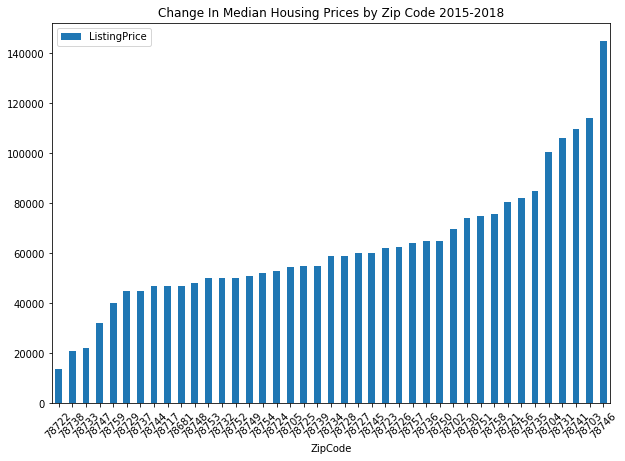

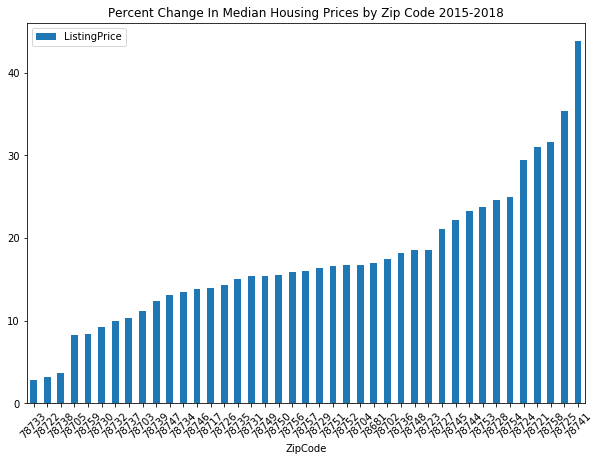

In [50]:
listings_csv = "Datasets/AustinHomePrice/ABoRListings.csv"
zips_csv = "Datasets/AustinPopulation/AustinZipCodePopulation.csv"


listings_df = pd.read_csv(listings_csv)
listings_df = listings_df.dropna()
listings_df.rename(columns={'ListingZipCode': 'ZipCode'}, inplace=True)

zip_df = pd.read_csv(zips_csv) # get updated list of zips from Ahmar
zip_df.rename(columns={'Zipcode': 'ZipCode'}, inplace=True)


# merge the dataframes
merge_listings_df = pd.merge(listings_df,zip_df,on='ZipCode')
merge_listings_df['ZipCode'] = (merge_listings_df['ZipCode']).astype(int)
merge_listings_df['ListingPrice'] = (merge_listings_df['ListingPrice']).astype(int)
merge_listings_df.drop('2015_Population', axis=1, inplace=True)
merge_listings_df.drop('2016_Population', axis=1, inplace=True)
merge_listings_df.drop('2017_Population', axis=1, inplace=True)
merge_listings_df.drop('2018_Population', axis=1, inplace=True)


# remove zip codes where there are less than 100 listings
count_listings_df = merge_listings_df.groupby(['ZipCode'])['ListingId'].count().to_frame()
count_listings_df.reset_index(inplace=True)
# count_listings_df

zips_to_include_df = count_listings_df[count_listings_df['ListingId'] > 100]  

# now merge back to original dataframe
# remove_listings_grouped_df

merge_listings_df = pd.merge(merge_listings_df,zips_to_include_df,on='ZipCode')
merge_listings_df.drop('ListingId_y', axis=1, inplace=True)
merge_listings_df.rename(columns={'ListingId_x': 'ListingId'}, inplace=True)


# now get median price per year for each year
final_listings_grouped_df = merge_listings_df.groupby(['ZipCode', 'ListingYear'])['ListingPrice'].median().to_frame()
final_listings_grouped_df.reset_index(inplace=True)
final_listings_grouped_df['ListingPrice'] = (final_listings_grouped_df['ListingPrice']).astype(int)

final_listings_grouped_df = final_listings_grouped_df.pivot(index='ZipCode', columns='ListingYear', values='ListingPrice')

# now get median price per year for each year
final_listings_plot_df = merge_listings_df.groupby(['ZipCode', 'ListingYear'])['ListingPrice'].median().to_frame()
final_listings_plot_df.reset_index(inplace=True)
final_listings_plot_df['ListingPrice'] = (final_listings_plot_df['ListingPrice']).astype(int)

final_listings_plot_2015_df = final_listings_plot_df['ListingPrice'] = 2015

# calculate year over year price increase/decreases in %
perc_change_listing_yoy = (final_listings_grouped_df.pct_change(axis='columns', fill_method='ffill'))*100


# then get 2018 over 2015 price increase/decrease in %
final_listings_2015_2018_df = merge_listings_df 

final_listings_2015_2018_df = final_listings_2015_2018_df[final_listings_2015_2018_df.ListingYear != 2016]
final_listings_2015_2018_df = final_listings_2015_2018_df[final_listings_2015_2018_df.ListingYear != 2017]
final_listings_2015_2018_df

final_listings_grouped_2015_2018_df = final_listings_2015_2018_df.groupby(['ZipCode', 'ListingYear'])['ListingPrice'].median().to_frame()
final_listings_grouped_2015_2018_df.reset_index(inplace=True)
final_listings_grouped_2015_2018_df['ListingPrice'] = (final_listings_grouped_2015_2018_df['ListingPrice']).astype(int)

final_listings_grouped_2015_2018_df = final_listings_grouped_2015_2018_df.pivot(index='ZipCode', columns='ListingYear', values='ListingPrice')


# calculate year over year price increase/decreases in %
perc_change_listing_2015_2018 = (final_listings_grouped_2015_2018_df.pct_change(axis='columns', fill_method='ffill'))*100


total_change_listing_2015_2018 = (final_listings_grouped_2015_2018_df.diff(axis='columns'))
total_change_listing_2015_2018 = total_change_listing_2015_2018.unstack().reset_index(name='ListingPrice')
total_change_listing_2015_2018 = total_change_listing_2015_2018.dropna()
total_change_listing_2015_2018.sort_values(by=['ListingPrice'], inplace=True)
ax = total_change_listing_2015_2018.plot(kind='bar',x='ZipCode',y='ListingPrice', rot=45, figsize=(10,7), title='Change In Median Housing Prices by Zip Code 2015-2018')
plt.savefig("images/chg_in_median_price.png")

pct_change_listing_2015_2018 = (final_listings_grouped_2015_2018_df.pct_change(axis='columns', fill_method='ffill'))*100
pct_change_listing_2015_2018 = pct_change_listing_2015_2018.unstack().reset_index(name='ListingPrice')
pct_change_listing_2015_2018 = pct_change_listing_2015_2018.dropna()
pct_change_listing_2015_2018.sort_values(by=['ListingPrice'], inplace=True)
ax = pct_change_listing_2015_2018.plot(kind='bar',x='ZipCode',y='ListingPrice', rot=45, figsize=(10,7), title='Percent Change In Median Housing Prices by Zip Code 2015-2018')
plt.savefig("images/per_chg_in_median_price.png")

In [51]:
per_chg_crime_price_merge = pd.merge(perc_chg_pop_crime_2015to2018, perc_change_listing_2015_2018, on='ZipCode')
per_chg_crime_price_merge.head()

,CrimePerPop2015,CrimePerPop2016,CrimePerPop2017,CrimePerPop2018,2015,2018
ZipCode,,,,,,
78702,NaN,NaN,NaN,-5.553800,NaN,17.475000
78703,NaN,NaN,NaN,-8.826972,NaN,11.121951
78704,NaN,NaN,NaN,-7.016709,NaN,16.747289
78705,NaN,NaN,NaN,-29.603636,NaN,8.320611
78717,NaN,NaN,NaN,29.362962,NaN,13.913751


In [52]:
per_chg_crime_price_merge.columns = ['CrimePerPop2015', 'CrimePerPop2016', 'CrimePerPop2017', \
                      'CrimePerPop2018', '2015', '2018']
per_chg_crime_price_merge = per_chg_crime_price_merge[['CrimePerPop2018', '2018']]
per_chg_crime_price_merge.head()

,CrimePerPop2018,2018
ZipCode,,
78702,-5.553800,17.475000
78703,-8.826972,11.121951
78704,-7.016709,16.747289
78705,-29.603636,8.320611
78717,29.362962,13.913751


p-value is: 0.4772704658264202
r-value is: -0.12417362635059245
r-square is: 0.01541908948105655


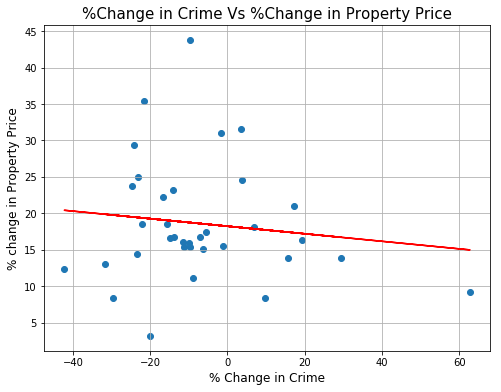

In [53]:
x = per_chg_crime_price_merge["CrimePerPop2018"]
y = per_chg_crime_price_merge["2018"]
stats = linregress(x,y)

m = stats.slope
b = stats.intercept
r_value = stats.rvalue
r_square = r_value**2
print(f"p-value is: {stats.pvalue}")
print(f"r-value is: {stats.rvalue}")
print(f"r-square is: {r_square}")
plt.figure(figsize = (8,6))
plt.scatter(x,y)
plt.plot(x, m*x+b, color = "red")

plt.xlabel("% Change in Crime", fontsize=12)
plt.ylabel("% change in Property Price", fontsize=12)
plt.title("%Change in Crime Vs %Change in Property Price", fontsize=15)
plt.grid()
plt.savefig("images/CrimeVsPropertyScatterPlt.png")
plt.show()

# Observations


* Total Crime per Category

| Category | No Of Crime |
| -------- | ----------- |
| Other | 289840 |
| Theft | 104969 |
| Burglary | 18521 |
| Auto Theft | 8425 |
| Aggravated Assault | 8268 |
| Robbery | 3765 |
| Rape | 2794 |
| Murder | 118 |

* Zipcode with five highest and five lowest number of crime per 1000 population over four years 2015 to 2018.

| ZipCode | No Of Crime |
| ------- | ----------- |
| 78728 | 2.423664 |
| 78730 | 25.608144 |
| 78725 | 26.142013 |
| 78739 | 28.394665 |
| 78717 | 43.491946 |
| 78723 | 241.512240 |
| 78702 | 289.902102 |
| 78742 | 298.824411 |
| 78719 | 373.789304 |
| 78701 | 1072.227312 |

* Zipcode with 5 highest and 5 lowest % change in crime over four years 2015 to 2018.

| ZipCode | No Of Crime |
| ------- | ----------- |  
| 78739 | -42.226029 |
| 78719 | -32.826218 |
| 78747 | -31.609205 |
| 78705 | -29.603636 |
| 78753 | -24.592798 |
| 78727 | 17.179695 |
| 78729 | 19.216242 |
| 78717 | 29.362962 |
| 78730 | 62.770642 |
| 78742 | 111.698113 |

* %Change in Violent Crime is getting reduced while %Change in Property Crime is getting increased over the four year from 2015 to 2018.
    * From 2017 to 2018, Violent crime has been decreased by 5%, while Property crime has been increased by 7%.
* February is the month with lowest crimes. October is the month with comparatively high crime based on four year total crime.
* Crime occurs relatively higher on Friday although there is not more changes.

* Based on scatterplot and derived r-square value, currently, it does not appear that crime data has a significant influence on home prices in Austin.
* Other factors such as neighborhood location, schools, walkability, neighborhood character, property taxes and long-term value may be more important.
